<a href="https://colab.research.google.com/github/Yadukrishnan1/NLP/blob/main/NLTK/summarization_nltk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
PATH='/content/drive/MyDrive/Colab_Notebooks/NLP/Summarization'
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [104]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [105]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [106]:
! pip install keras-attention
! pip install feedparser

In [ ]:
!ls /content/gdrive/MyDrive/Colab_Notebooks/NLP/Summarization/

attention.py  summarization_nltk.ipynb


In [173]:
"""
python_arXiv_parsing

Please see the documentation at 
http://export.arxiv.org/api_help/docs/user-manual.html
"""

import urllib
import pandas as pd
import feedparser

# Base api query url
base_url = 'http://export.arxiv.org/api/query?';

# Search parameters
search_query = 'all:economics' # search for electron in all fields
start = 0                     # retreive the first 5 results
max_results = 100

query = 'search_query=%s&start=%i&max_results=%i' % (search_query,
                                                     start,
                                                     max_results)

# Opensearch metadata such as totalResults, startIndex, 
# and itemsPerPage live in the opensearch namespase.
# Some entry metadata lives in the arXiv namespace.
# This is a hack to expose both of these namespaces in
# feedparser v4.1

# feedparser._FeedParserMixin.namespaces['http://a9.com/-/spec/opensearch/1.1/'] = 'opensearch'
# feedparser._FeedParserMixin.namespaces['http://arxiv.org/schemas/atom'] = 'arxiv'

# perform a GET request using the base_url and query
response = urllib.request.urlopen(base_url+query).read()

# parse the response using feedparser
feed = feedparser.parse(response)

# print out feed information
# print ('Feed title: {}'.format(feed.feed.title))
# print ('Feed last updated: {}'.format(feed.feed.updated))

# print opensearch metadata
# print ('totalResults for this query: {}'.format(feed.feed.opensearch_totalresults))
# print ('itemsPerPage for this query: {}'.format(feed.feed.opensearch_itemsperpage))
# print ('startIndex for this query: {}'  .format(feed.feed.opensearch_startindex))

# Run through each entry, and print out information
title_list=[]
abstract_list=[]
for entry in feed.entries:
    title_list.append(entry.title)
    
    # The abstract is in the <summary> element
    abstract_list.append(entry.summary)

data = pd.DataFrame(list(zip(title_list, abstract_list)), columns=['title','abstract'])


In [174]:
data.drop_duplicates(subset=['abstract', 'title'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [175]:
data.head()

,title,abstract
0,The Link Between Standardization and Economic Growth: A Bibliometric\n Analysis,"We analyze the link between standardization and economic growth by\nsystematically reviewing leading economics journals, leading economic growth\nresearchers' articles, and economic growth-related..."
1,Business Cycles as Collective Risk Fluctuations,"We suggest use continuous numerical risk grades [0,1] of R for a single risk\nor the unit cube in Rn for n risks as the economic domain. We consider risk\nratings of economic agents as their coord..."
2,"Econophysics of Macroeconomics: ""Action-at-a-Distance"" and Waves",We present macroeconomic model that describes evolution of macroeconomic\nvariables and macroeconomic waves on economic space. Risk ratings of economic\nagents play role of their coordinates on ec...
3,Econophysics Macroeconomic Model,This paper presents macroeconomic model that is based on parallels between\nmacroeconomic multi-agent systems and multi-particle systems. We use risk\nratings of economic agents as their coordinat...
4,Economic prospects of the Russian-Chinese partnership in the logistics\n projects of the Eurasian Economic Union and the Silk Road Economic Belt: a\n scientific literature review,The authors of the article have reviewed the scientific literature on the\ndevelopment of the Russian-Chinese cooperation in the field of combining\neconomic and logistics projects of the Eurasian...


In [176]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

Cleaning of the Abstracts (long texts)

In [177]:
stop_words = set(stopwords.words('english')) 
def abstract_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_abstract = []
for t in data['abstract']:
    cleaned_abstract.append(abstract_cleaner(t))

In [178]:
def title_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_title = []
for t in data['title']:
    cleaned_title.append(title_cleaner(t))


In [179]:
data['cleaned_abstract']=cleaned_abstract
data['cleaned_title']=cleaned_title
data['cleaned_title'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [180]:
data.head()

,title,abstract,cleaned_abstract,cleaned_title
0,The Link Between Standardization and Economic Growth: A Bibliometric\n Analysis,"We analyze the link between standardization and economic growth by\nsystematically reviewing leading economics journals, leading economic growth\nresearchers' articles, and economic growth-related...",analyze link standardization economic growth systematically reviewing leading economics journals leading economic growth researchers articles economic growth related books make following observati...,the link between standardization and economic growth bibliometric analysis
1,Business Cycles as Collective Risk Fluctuations,"We suggest use continuous numerical risk grades [0,1] of R for a single risk\nor the unit cube in Rn for n risks as the economic domain. We consider risk\nratings of economic agents as their coord...",suggest use continuous numerical risk grades single risk unit cube risks economic domain consider risk ratings economic agents coordinates economic domain economic activity agents economic factors...,business cycles as collective risk fluctuations
2,"Econophysics of Macroeconomics: ""Action-at-a-Distance"" and Waves",We present macroeconomic model that describes evolution of macroeconomic\nvariables and macroeconomic waves on economic space. Risk ratings of economic\nagents play role of their coordinates on ec...,present macroeconomic model describes evolution macroeconomic variables macroeconomic waves economic space risk ratings economic agents play role coordinates economic space aggregation economic va...,econophysics of macroeconomics action at distance and waves
3,Econophysics Macroeconomic Model,This paper presents macroeconomic model that is based on parallels between\nmacroeconomic multi-agent systems and multi-particle systems. We use risk\nratings of economic agents as their coordinat...,paper presents macroeconomic model based parallels macroeconomic multi agent systems multi particle systems use risk ratings economic agents coordinates economic space aggregates economic financia...,econophysics macroeconomic model
4,Economic prospects of the Russian-Chinese partnership in the logistics\n projects of the Eurasian Economic Union and the Silk Road Economic Belt: a\n scientific literature review,The authors of the article have reviewed the scientific literature on the\ndevelopment of the Russian-Chinese cooperation in the field of combining\neconomic and logistics projects of the Eurasian...,authors article reviewed scientific literature development russian chinese cooperation field combining economic logistics projects eurasian economic union silk road economic belt opinions russian ...,economic prospects of the russian chinese partnership in the logistics projects of the eurasian economic union and the silk road economic belt scientific literature review


In [181]:
data['cleaned_title'] = data['cleaned_title'].apply(lambda x : '_START_ '+ x + ' _END_')

In [182]:
for i in range(5):
    print("Abstract:",data['cleaned_abstract'][i])
    print("Title:",data['cleaned_title'][i])
    print("\n")

Abstract: analyze link standardization economic growth systematically reviewing leading economics journals leading economic growth researchers articles economic growth related books make following observations article analyzed link standardization economic growth top economics journals representative sample leading researchers economic growth allocated little attention link standardization economic growth typically economic growth textbooks contain standards standardization word indexes findings suggest economic growth theory neglected role standardization
Title: _START_ the link between standardization and economic growth bibliometric analysis  _END_


Abstract: suggest use continuous numerical risk grades single risk unit cube risks economic domain consider risk ratings economic agents coordinates economic domain economic activity agents economic factors change agents risk ratings cause motion agents economic domain aggregations variables transactions individual agents small volume e

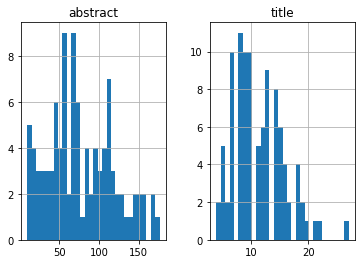

In [183]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_abstract']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_title']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'abstract':text_word_count, 'title':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [184]:
max_len_abstract=200 
max_len_title=30

In [185]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_abstract'],data['cleaned_title'],test_size=0.1,random_state=0,shuffle=True)

In [186]:
print('x_tr shape - ', x_tr.shape)
print('y_tr shape - ', y_tr.shape)

x_tr shape -  (90,)
y_tr shape -  (90,)


In [187]:
x_tr.head()

53    deep neural networks increasingly applied choice analysis showing high predictive power unclear extent researchers interpret economic information dnns paper demonstrates dnns provide economic info...
92            propose novel method wasserstein index generation model generate public sentiment index automatically test model effectiveness application generate economic policy uncertainty index showcased
78    found human mobility exhibits random patterns following levy flight human movement contains many short flights long flights flights follow power law distribution paper study social economical deve...
13    development growth complex tumultuous processes modern economic growth theories identify key determinants economic growth however relative importance determinants remains unknown additional variab...
7     growing awareness within economics profession important role narratives play economy even though empirical approaches try quantify economic narratives getting increasingl

In [188]:
y_tr.head()

53                            _START_ deep neural networks for choice analysis extracting complete economic information for interpretation  _END_
92    _START_ wasserstein index generation model automatic generation of time series index with application to economic policy uncertainty  _END_
78                                          _START_ the levy flight of cities analyzing social economical trajectories with auto embedding  _END_
13                                                                        _START_ the role of complex analysis in modeling economic growth  _END_
7                                                                                                          _START_ narratives in economics  _END_
Name: cleaned_title, dtype: object

In [189]:
#prepare a tokenizer for abstracts on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_abstract, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_abstract, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [190]:
#preparing a tokenizer for title on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_title, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_title, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [191]:
print('x_tr shape - ', x_tr.shape)
print('y_tr shape - ', y_tr.shape)

x_tr shape -  (90, 200)
y_tr shape -  (90, 30)


In [192]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_len_abstract,))

#embedding layer
enc_emb =  Embedding(x_voc_size, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)


#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc_size, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 200)     447800      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 200, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [193]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [194]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [195]:
print(y_tr[:,:-1].shape)
print(x_tr.shape)

(90, 29)
(90, 200)


In [196]:
history=model.fit([x_tr, y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
1/1 [==============================] - 34s 34s/step - loss: 5.9986 - val_loss: 5.6607
Epoch 2/50
1/1 [==============================] - 16s 16s/step - loss: 5.7157 - val_loss: 1.9767
Epoch 2: early stopping


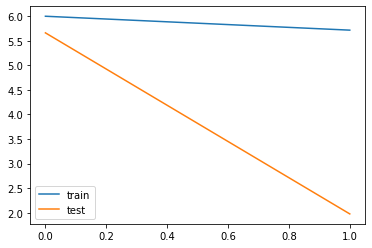

In [197]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [198]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [199]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_abstract,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [205]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_abstract-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [206]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [207]:
for i in range(0,5):
    print("Review:", seq2text(x_tr[i]))
    print("Original summary:", seq2text(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_abstract)))
    print("\n")

Review: deep neural networks increasingly applied choice analysis showing high predictive power unclear extent researchers interpret economic information dnns paper demonstrates dnns provide economic information complete classical discrete choice models economic information includes choice predictions choice probabilities market shares substitution patterns alternatives social welfare probability derivatives elasticities marginal rates substitution heterogeneous values time unlike dcms dnns automatically learn utility function reveal behavioral patterns prespecified domain experts however economic information obtained dnns unreliable three challenges associated automatic learning capacity high sensitivity hyperparameters model non identification local irregularity demonstrate strength challenges dnns estimated dnns using stated preference survey extracted full list economic information dnns compared dcms found economic information either aggregated trainings population reliable disaggr

KeyError: ignored